In [6]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as pkgdt
import requests 
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as cx
import folium
from requests.adapters import HTTPAdapter

In [7]:
r = requests.get(
    "https://velib-metropole-opendata.smoove.pro/opendata/Velib_Metropole/station_information.json",
    headers = ''
)

if r.status_code != 200: # see HTTP errors
    print("HTTP ERROR")
else:  
    r.text
    infoStations = pd.DataFrame(pd.DataFrame(r.json())["data"]["stations"]) 

In [8]:
infoStations.describe()

,station_id,lat,lon,capacity
count,1.449000e+03,1449.000000,1449.000000,1449.000000
mean,1.028074e+09,48.858388,2.341179,31.228433
std,3.011242e+09,0.030305,0.056514,11.950271
min,6.245000e+03,48.764615,2.165597,0.000000
25%,5.400119e+07,48.837809,2.302569,23.000000
50%,1.291357e+08,48.858535,2.343826,29.000000
75%,6.500918e+08,48.879355,2.378623,37.000000
max,1.704710e+10,48.951432,2.538242,74.000000


In [9]:
r = requests.get(
   "https://velib-metropole-opendata.smoove.pro/opendata/Velib_Metropole/station_status.json",
    headers = ''
)

if r.status_code != 200: # see HTTP errors
    print("HTTP ERROR")
else:  
    r.text
    statusStations = pd.DataFrame(pd.DataFrame(r.json())["data"]["stations"])

api_url= "https://data.iledefrance.fr/api/records/1.0/search/?dataset=iris&q=&facet=dep&facet=typ_iris"

#api_pwd ='357b149b931893ee9e6ece99609651cf136256d17d2763b930dfd278'

    
headers = {'Accept':'application/json'}
req = requests.get(api_url, headers = headers)
open('Data.xml', 'wb').write(req.content)
zonesIris = pd.DataFrame(req.json()["records"])["fields"]
zonesIris = pd.json_normalize(zonesIris)
#test = Polygon
#zonesIris.geometry = [Polygon(eval(xy_string)) for xy_string in zonesIris["geo_shape.coordinates"]]

for i in zonesIris.index:
    zonesIris.loc[i,"geometry"] = Polygon(zonesIris["geo_shape.coordinates"][i][0])
zonesIris.drop(['geo_shape.coordinates', 'geo_shape.type', "geo_point", "code_iris"],axis=1, inplace=True)

zonesIris = gpd.GeoDataFrame(zonesIris, geometry=zonesIris.geometry)

In [10]:
zonesIris = gpd.read_file("C:\\Users\\Rania\\Downloads\\iris\\iris.shp")
zonesIris.head()

,dep,insee_com,nom_com,iris,code_iris,nom_iris,typ_iris,geometry
0,75.0,75105.0,Paris 5e Arrondissement,1907.0,751051907.0,Val de Grace 7,H,"POLYGON ((2.34364 48.84122, 2.34424 48.84245, ..."
1,75.0,75107.0,Paris 7e Arrondissement,2807.0,751072807.0,Gros Caillou 7,H,"POLYGON ((2.30090 48.85113, 2.29990 48.85173, ..."
2,75.0,75108.0,Paris 8e Arrondissement,3103.0,751083103.0,Madeleine 3,A,"POLYGON ((2.31961 48.87451, 2.31962 48.87449, ..."
3,75.0,75111.0,Paris 11e Arrondissement,4318.0,751114318.0,Roquette 18,H,"POLYGON ((2.38202 48.86019, 2.38281 48.85939, ..."
4,75.0,75111.0,Paris 11e Arrondissement,4114.0,751114114.0,Folie Mericourt 14,H,"POLYGON ((2.37303 48.87062, 2.37301 48.87041, ..."


In [11]:
statusStations["num_bikes_mechanical"] = statusStations['num_bikes_available_types'][0][0]["mechanical"]
statusStations["num_bikes_ebike"] = statusStations['num_bikes_available_types'][0][1]["ebike"]

In [12]:
for i in statusStations.index:
    statusStations.loc[i,"num_bikes_mechanical"] = statusStations.loc[i,'num_bikes_available_types'][0]["mechanical"]
    statusStations.loc[i,"num_bikes_ebike"] = statusStations.loc[i,'num_bikes_available_types'][1]["ebike"]
statusStations.drop(['num_bikes_available_types', 'stationCode'],axis=1, inplace=True)

In [13]:
statusStations.head()

,station_id,num_bikes_available,numBikesAvailable,num_docks_available,numDocksAvailable,is_installed,is_returning,is_renting,last_reported,num_bikes_mechanical,num_bikes_ebike
0,213688169,1,1,34,34,1,1,1,1672769080,1,0
1,653222953,5,5,24,24,1,1,1,1672769038,1,4
2,516709288,1,1,19,19,1,1,1,1672769100,1,0
3,36255,3,3,17,17,1,1,1,1672768983,0,3
4,37815204,13,13,14,14,1,1,1,1672769295,9,4


In [14]:
statusStations.set_index("station_id", inplace=True)
infoStations.set_index("station_id", inplace=True)

In [15]:
statusStations = statusStations.join(infoStations)
statusStations.head()

,num_bikes_available,numBikesAvailable,num_docks_available,numDocksAvailable,is_installed,is_returning,is_renting,last_reported,num_bikes_mechanical,num_bikes_ebike,name,lat,lon,capacity,stationCode,rental_methods
station_id,,,,,,,,,,,,,,,,
213688169,1,1,34,34,1,1,1,1672769080,1,0,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,16107,NaN
653222953,5,5,24,24,1,1,1,1672769038,1,4,Mairie de Rosny-sous-Bois,48.871257,2.486581,30,31104,[CREDITCARD]
516709288,1,1,19,19,1,1,1,1672769100,1,0,Charonne - Robert et Sonia Delauney,48.855908,2.392571,20,11104,NaN
36255,3,3,17,17,1,1,1,1672768983,0,3,Toudouze - Clauzel,48.879296,2.337360,21,9020,[CREDITCARD]
37815204,13,13,14,14,1,1,1,1672769295,9,4,Mairie du 12ème,48.840855,2.387555,30,12109,NaN


In [16]:
gdf = gpd.GeoDataFrame(statusStations, geometry=gpd.points_from_xy(infoStations.lon, infoStations.lat))

C:\Users\Rania\anaconda3\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [17]:
#gdf.set_crs(epsg=4326, inplace=True)

In [18]:
#stationsIris = gpd.sjoin(gdf, zonesIris, op='within')
stationsIris = gpd.sjoin(zonesIris, gdf, op='contains')

C:\Users\Rania\AppData\Local\Temp\ipykernel_25312\1151765979.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  stationsIris = gpd.sjoin(zonesIris, gdf, op='contains')


In [19]:
stationsIris[stationsIris["insee_com"]==75105.0]

,dep,insee_com,nom_com,iris,code_iris,nom_iris,typ_iris,geometry,index_right,num_bikes_available,...,is_renting,last_reported,num_bikes_mechanical,num_bikes_ebike,name,lat,lon,capacity,stationCode,rental_methods
0,75.0,75105.0,Paris 5e Arrondissement,1907.0,751051907.0,Val de Grace 7,H,"POLYGON ((2.34364 48.84122, 2.34424 48.84245, ...",2515049357,1,...,1,1672769288,1,0,Erasme - Ulm,48.842644,2.344595,24,5124,NaN
546,75.0,75105.0,Paris 5e Arrondissement,1908.0,751051908.0,Val de Grace 8,H,"POLYGON ((2.34983 48.83879, 2.34933 48.83899, ...",653044270,3,...,1,1672769294,0,3,Claude Bernard - Arbalète,48.839767,2.347511,17,5114,NaN
546,75.0,75105.0,Paris 5e Arrondissement,1908.0,751051908.0,Val de Grace 8,H,"POLYGON ((2.34983 48.83879, 2.34933 48.83899, ...",34235349,1,...,1,1672769340,1,0,Jean Calvin - Tournefort,48.841589,2.348490,28,5014,NaN
548,75.0,75105.0,Paris 5e Arrondissement,1805.0,751051805.0,Jardin des Plantes 5,H,"POLYGON ((2.35658 48.83969, 2.35633 48.84023, ...",1062783107,5,...,1,1672769370,3,2,Buffon - Jardin des Plantes,48.842668,2.361859,30,5115,[CREDITCARD]
1137,75.0,75105.0,Paris 5e Arrondissement,1801.0,751051801.0,Jardin des Plantes 1,H,"POLYGON ((2.35658 48.83969, 2.35815 48.83997, ...",11580442,3,...,1,1672769290,3,0,Geoffroy-Saint-Hilaire - Saint-Marcel,48.839078,2.356877,17,5105,NaN
1217,75.0,75105.0,Paris 5e Arrondissement,2004.0,751052004.0,Sorbonne 4,H,"POLYGON ((2.34660 48.84914, 2.34586 48.84932, ...",647826568,24,...,1,1672769352,19,5,Saint-Germain - Thenard,48.850571,2.347101,31,5123,[CREDITCARD]
1217,75.0,75105.0,Paris 5e Arrondissement,2004.0,751052004.0,Sorbonne 4,H,"POLYGON ((2.34660 48.84914, 2.34586 48.84932, ...",653050378,23,...,1,1672769364,19,4,Square René Viviani - Montebello,48.851905,2.347842,34,5121,[CREDITCARD]
1558,75.0,75105.0,Paris 5e Arrondissement,1702.0,751051702.0,Saint-Victor 2,H,"POLYGON ((2.35166 48.84660, 2.35279 48.84595, ...",84961467,17,...,1,1672769292,15,2,Lacépède - Linné,48.843704,2.354651,54,5031,[CREDITCARD]
1558,75.0,75105.0,Paris 5e Arrondissement,1702.0,751051702.0,Saint-Victor 2,H,"POLYGON ((2.35166 48.84660, 2.35279 48.84595, ...",72765603,8,...,1,1672769287,5,3,Boulangers - Cardinal Lemoine,48.846290,2.352149,20,5022,[CREDITCARD]
1567,75.0,75105.0,Paris 5e Arrondissement,1705.0,751051705.0,Saint-Victor 5,H,"POLYGON ((2.35612 48.84935, 2.35448 48.84939, ...",100770878,20,...,1,1672769349,19,1,Poissy - Saint-Germain,48.849696,2.352969,25,5019,[CREDITCARD]


In [14]:
countNumBikes = stationsIris.groupby('nom_com').agg({'num_bikes_available': ['min', 'max', "mean", "sum"], 
                                  'num_docks_available': ['min', 'max', "mean", "sum"]})

In [21]:
test = stationsIris.groupby(['nom_com'])['num_bikes_available'].agg('sum')

In [35]:
test

nom_com
Alfortville             86
Arcueil                 14
Argenteuil              80
AsniÃ¨res-sur-Seine    134
Aubervilliers          163
                      ... 
Vanves                  53
Ville-d'Avray            0
Villejuif               20
Vincennes               47
Vitry-sur-Seine        243
Name: num_bikes_available, Length: 80, dtype: int64

In [16]:
countNumBikes = countNumBikes.join(stationsIris.set_index("nom_com"))

C:\Users\Rania\AppData\Local\Temp\ipykernel_25556\1375090238.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  countNumBikes = countNumBikes.join(stationsIris.set_index("nom_com"))


In [17]:
countNumBikes = gpd.GeoDataFrame(countNumBikes, geometry=countNumBikes.geometry)

In [18]:
countNumBikes.columns

Index([ ('num_bikes_available', 'min'),  ('num_bikes_available', 'max'),
       ('num_bikes_available', 'mean'),  ('num_bikes_available', 'sum'),
        ('num_docks_available', 'min'),  ('num_docks_available', 'max'),
       ('num_docks_available', 'mean'),  ('num_docks_available', 'sum'),
                                 'dep',                     'insee_com',
                                'iris',                     'code_iris',
                            'nom_iris',                      'typ_iris',
                            'geometry',                   'index_right',
                 'num_bikes_available',             'numBikesAvailable',
                 'num_docks_available',             'numDocksAvailable',
                        'is_installed',                  'is_returning',
                          'is_renting',                 'last_reported',
                'num_bikes_mechanical',               'num_bikes_ebike',
                                'name',            

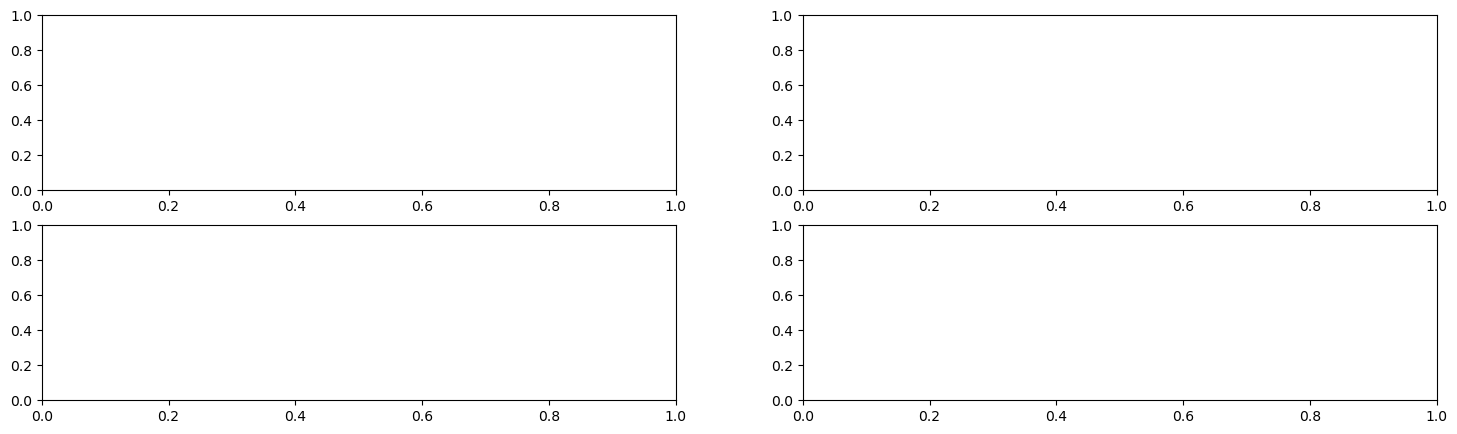

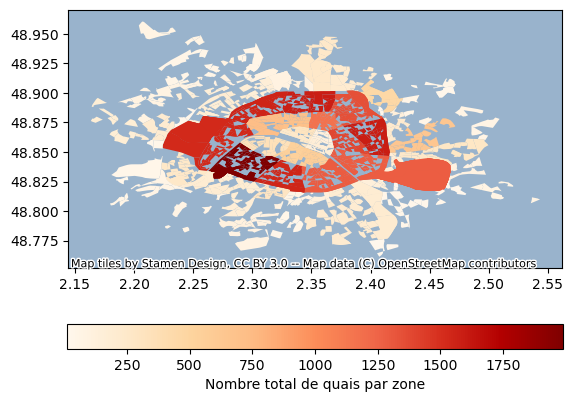

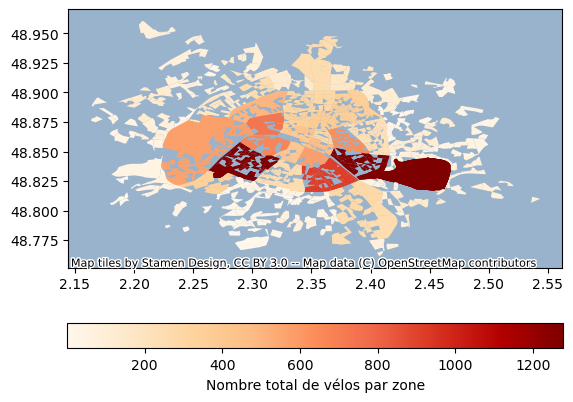

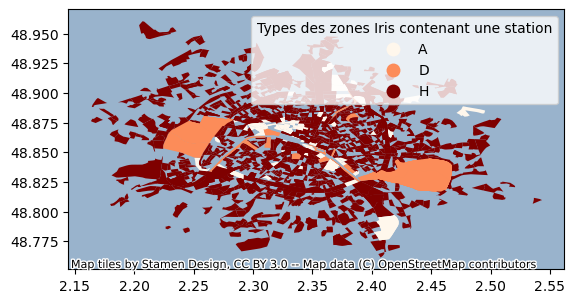

In [27]:
#pour une raison inconnue je n'ai toujours pas de carte, je ne dois pas être sur le bon crs 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 5))
ax[0,0] = countNumBikes.plot(('num_docks_available', 'sum'), 
              #alpha=0.5,
              legend=True,
              cmap='OrRd',
              #scheme='quantiles',
              legend_kwds={'label': "Nombre total de quais par zone",
                        'orientation': "horizontal"})

ax[0,1] = countNumBikes.plot(('num_bikes_available', 'sum'), 
              #alpha=0.5,
              legend=True,
              cmap='OrRd',
              #scheme='quantiles',
              legend_kwds={'label': "Nombre total de vélos par zone",
                        'orientation': "horizontal"})

ax[1,0] = countNumBikes.plot('typ_iris', 
              #alpha=0.5,
              legend=True,
              cmap='OrRd',
              #scheme='quantiles',
              legend_kwds={'title': "Types des zones Iris contenant une station"})

"""ax[1,1] = countNumBikes.plot('rental_methods', 
              #alpha=0.5,
              legend=True,
              cmap='OrRd',
              #scheme='quantiles',
              legend_kwds={'title': "Nombre total de quais par zone"})"""
cx.add_basemap(ax[0,0], zoom = 15)
cx.add_basemap(ax[1,0], zoom = 15)
cx.add_basemap(ax[0,1], zoom = 15)
#cx.add_basemap(ax[1,1], zoom = 15)

In [ ]:
#J'ai testé ça : j'arrive pas à avoir le background sur la carte, mais j'ai réussi à avoir un truc interactif juste en dessous ! 
ax = gdf.plot("num_bikes_mechanical", 
              alpha=0.5, 
              legend=True, 
              legend_kwds={'label': "Nombre de vélos mécaniques par station",
                        'orientation': "horizontal"})
cx.add_basemap(ax, zoom = 15)

df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = df.plot(figsize=(5, 5), alpha=0.5, edgecolor='k')
df_wm = df.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(5, 5), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)

In [ ]:
import matplotlib.colors as colors
gdf.explore("num_bikes_mechanical", 
            #cmap=colors.ListedColormap(mpl.colormaps['viridis']),
              legend=True,            
              legend_kwds={'label': "Nombre de vélos mécaniques par station",
                           'color' :"R",
                           
                        'orientation': "horizontal"})

In [ ]:
def read_shapefile(shp_path):
	"""
	Read a shapefile into a Pandas dataframe with a 'coords' column holding
	the geometry information. This uses the pyshp package
	"""
	import shapefile

	#read file, parse out the records and shapes
	sf = shapefile.Reader(shp_path)
	fields = [x[0] for x in sf.fields][1:]
	records = sf.records()
	shps = [s.points for s in sf.shapes()]

	#write into a dataframe
	df = pd.DataFrame(columns=fields, data=records)
	df = df.assign(coords=shps)

	return df

In [ ]:
 
shapefile_path = r"C:\\Users\\Rania\\Downloads\\CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01\\CONTOURS-IRIS\\1_DONNEES_LIVRAISON_2022-06-00180\\CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2022\\CONTOURS-IRIS.shp"
test = geopandas.read_file(shapefile_path)

In [ ]:
irisZones.plot()

In [ ]:
irisZones.INSEE_COM